(67761, 50170)
534


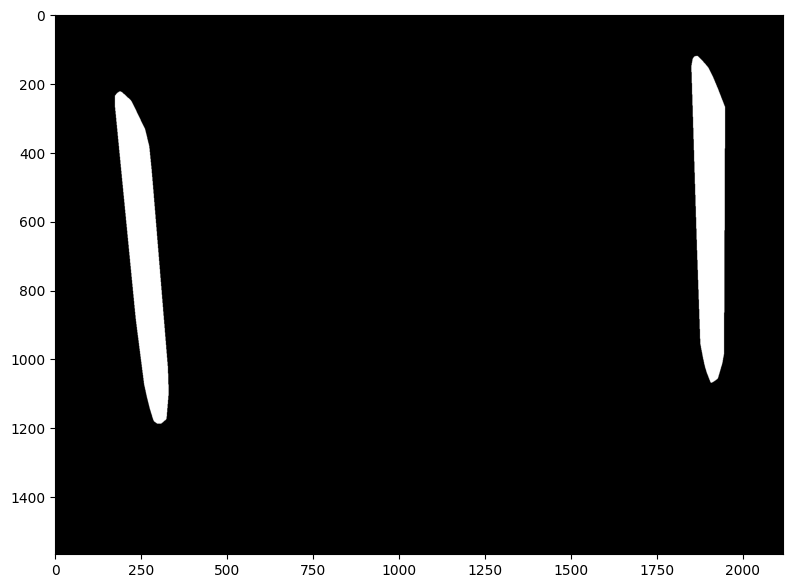

In [3]:
import cv2
import tiffslide as openslide
import numpy as np

import logging 

class Slide:
    def __init__(self, config, svsName) -> None:
        self.config = config
        self.svsName = svsName
        self.svsPath = f"{self.config['svsBase']}/{self.svsName}"
        self.s = openslide.open_slide(self.svsPath)

    def smoothBinary(self, mask):
        kn = 2
        iterat = 2
        kernel = np.ones((kn, kn), np.uint8) 
        for _ in range(iterat):
            mask = cv2.erode(mask, kernel, iterations=1) 
            mask = cv2.dilate(mask, kernel, iterations=1) 
        return mask

    def extractForeground(self):
        location = (0,0)
        level = self.s.level_count-1
        size = self.s.level_dimensions[self.s.level_count-1]
        lr = np.array(self.s.read_region(location, level, size))[:,:,:3]

        lrGray = cv2.cvtColor(lr, cv2.COLOR_RGB2GRAY)

        _, thre = cv2.threshold(lrGray, 220, 255, cv2.THRESH_BINARY) # THreshold for White
        threTissue = 255-thre

        self.threTissueSmooth = self.smoothBinary(threTissue)

        thresholdArea = 0.7
        contours, _ = cv2.findContours(self.threTissueSmooth, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        c_max = max(contours, key = cv2.contourArea)
        area_min = cv2.contourArea(c_max) * thresholdArea

        contours_filtered = []

        for contour in contours:
            area = cv2.contourArea(contour)
            if area > area_min:
                contours_filtered.append(cv2.convexHull(contour, returnPoints=True))

        im_ = lrGray*0

        cv2.drawContours(im_, contours_filtered, -1, 255, -1)

        self.threTissueSmooth = np.copy(im_)
                
        return self.threTissueSmooth

    def extractPatches(self, patchSize):
        (w, h) = self.s.level_dimensions[0]
        wn = w//patchSize
        hn = h//patchSize
        self.threTissueSmoothResized = cv2.resize(self.threTissueSmooth, (wn, hn)) # Resize Binary Mask to align with Patches

        self.patches = {}

        for ix in range(wn):
            for iy in range(hn):
                if self.threTissueSmoothResized[iy, ix]==255:
                    try:
                        x = ix*patchSize
                        y = iy*patchSize
                        size = (patchSize, patchSize)
                        level = 0
                        location = (x,y)
                        self.patches[f'{x}_{y}'] = cv2.cvtColor(np.array(self.s.read_region(location, level, size))[:,:,:3], cv2.COLOR_RGB2BGR)
                    except:
                        logging.warning("Exception inside patch extraction")
        
        return self.patches

slideName = 'S-1908-009781_PAS_2of2.svs'
patchSize = 512

config = {
    'svsBase': '/blue/pinaki.sarder/nlucarelli/kpmp_new',
    'patchSize': 512
}

slide = Slide(config, slideName)

w, h = slide.s.level_dimensions[0]

fg = slide.extractForeground()

slide.extractPatches(patchSize)

print((w, h))

print(len(slide.patches))

import matplotlib.pyplot as plt

%matplotlib inline

keys = list(slide.patches)

fig = plt.figure(figsize = (20,7))

plt.imshow(fg, cmap='gray')





In [15]:
import cv2

import girder_client
import shapely
import tiffslide as openslide
import numpy as np
import os
import logging
import json

from modules.ftu import FTU, Tubule

import numpy as np

import argparse

class DSA:
    def __init__(self, config) -> None:
        self.config = config
        apiUrl = config['apiUrl']
        username = config['username']
        password = config['password']
        self.gc = girder_client.GirderClient(apiUrl=apiUrl)
        self.gc.authenticate(username, password)

    def postAnno(self, fid, annos):
        for anno in annos:
            anno = json.dumps(anno)
            method = "POST"
            path = "/annotation"
            r = self.gc.sendRestRequest(method, path, parameters={'itemId': fid}, data=anno)
        return

class DSAFolder(DSA):
    def __init__(self, config) -> None:
        super().__init__(config)
        folderid = config['fid']
        self.items = self.getItemsInDsaFolder(folderid)

    def getItemsInDsaFolder(self, dsaFolder):
        method = "GET"
        path = f"/item"
        r = self.gc.sendRestRequest(method, path, {'folderId': dsaFolder, 'limit': 1000})
        items = [(f['_id'], f['name']) for f in r if f['name'].endswith('.svs')]
        return items

class DSAItem(DSA):
    def __init__(self, config, fid, svsname) -> None:
        super().__init__(config)
        self.layerName = config['layerName']
        self.fid = fid
        self.svsname = svsname
        self.name = svsname.replace('.svs', '')
        self.svsBase = config['svsBase']
        self.annoRow = self.getAnnotationByLayerName(self.fid, self.layerName)
        self.annotationsShapely = self.convertAnnotations(self.getAnnotationByLayerName(self.fid, self.layerName))
        self.annoElems = self.annoRow['annotation']['elements']
        self.annotations = self.convertAnnotationsCV(self.getAnnotationByLayerName(self.fid, self.layerName))
        self.s = openslide.open_slide(f"{self.svsBase}/{self.svsname}")

    def getAnnotationByLayerName(self, id, name):

        method = "GET"
        path = f"/annotation"
        r = self.gc.sendRestRequest(method, path, {'itemId': id, 'limit': 1000})

        for anno in r:
            if anno['annotation']['name'] ==  name or anno['annotation']['name'] ==  f" {name}"or anno['annotation']['name'] ==  f"  {name}" :
                annoId = anno['_id']

        method = "GET"
        path = f"annotation/{annoId}"
        annotations = self.gc.sendRestRequest(method, path, {'id': annoId, 'limit': 10000000})
        return annotations

    def convertAnnotations(self, anno):
        annos = anno['annotation']['elements']
        annos_2 = []
        for a in annos:
            try:
                annos_2.append([(k[0], k[1]) for k in a['points']])
            except:
                pass
        annos_ = []
        for k in annos_2:
            if len(k)>4:
                annos_.append(shapely.Polygon(k))
        return annos_
    
    def convertAnnotationsCV(self, anno):
        annos = anno['annotation']['elements']
        annos_2 = []
        for a in annos:
            annos_2.append(np.array([[k[0], k[1]] for k in a['points']], dtype=np.int32))
        return annos_2
    
    def extract(self):
        outputdir = self.config['outputdir']

        if not os.path.exists(outputdir):
            os.mkdir(outputdir)
        
        for i in range(len(self.annotations)):
            try:
                patch, mask = self.getPatchMask(i)
                if self.config['masked']:
                    out = np.array(patch*(mask/255), dtype='uint8')
                else:
                    out = np.copy(patch)
                cv2.imwrite(f'{outputdir}/{self.name}_{i}_{self.x}_{self.y}.jpg', out)
            except:
                pass

    def getTubules(self):

        self.ftus = []
        
        for i in range(len(self.annotations)):
            patch, mask, bb = self.getPatchMask(i)
            self.ftus.append(Tubule({}, patch, mask, bb, self.annoElems[i]))

        return self.ftus

    def extractFixed(self, w, h):
        outputdir = self.config['outputdir']

        if not os.path.exists(outputdir):
            os.mkdir(outputdir)
        
        for i in range(len(self.annotations)):
            try:
                patch, mask = self.getPatchMaskFixed(i, w, h)
                if self.config['masked']:
                    out = np.array(patch*(mask/255), dtype='uint8')
                else:
                    out = np.copy(patch)
                cv2.imwrite(f'{outputdir}/{self.name}_{i}_{self.x}_{self.y}.jpg', out)
            except:
                pass

    def getMaxBB(self):
        
        w_max = 0
        h_max = 0
        for i in range(len(self.annotations)):
            try:
                w, h = self.getWH(i)
                w_max = max(w, w_max)
                h_max = max(h, h_max)
            except:
                pass
        return w_max, h_max

    def getWH(self, tid):
        polygon1 = self.annotations[tid]
        bb = polygon1.bounds
        w = int(bb[2]-bb[0])
        h = int(bb[3]-bb[1])
        
        return w, h

    def getPatchMask(self, tid):
        polygon1 = self.annotationsShapely[tid]
        x,y = polygon1.exterior.xy
        bb = polygon1.bounds

        size_1 = [int(bb[3]-bb[1]), int(bb[2]-bb[0])]

        mask = np.zeros(size_1)

        points = [[int(x-bb[0]), int(y-bb[1])] for x, y in zip(*polygon1.boundary.coords.xy)]

        mask = cv2.fillPoly(mask, np.array([points]).astype(np.int32), color=255)

        size_2 = [int(bb[2]-bb[0]), int(bb[3]-bb[1])]
        location = (int(bb[0]), int(bb[1]))

        self.x = int(bb[0])
        self.y = int(bb[1])
        self.w = int(bb[2]-bb[0])
        self.h = int(bb[3]-bb[1])
        self.polygon = polygon1

        level = 0

        patch = np.array(self.s.read_region(location, level, size_2))[:,:,:3]
        mask = cv2.cvtColor(np.array(mask, dtype='uint8'), cv2.COLOR_GRAY2RGB)
        
        return patch, mask, {'x':self.x, 'y':self.y, 'w':self.w, 'h':self.h}
    
    def getPatchMaskFixed(self, tid, w, h):
        polygon1 = self.annotations[tid]
        x,y = polygon1.exterior.xy
        bb = polygon1.bounds

        size_2 = [int(bb[2]-bb[0]), int(bb[3]-bb[1])]

        wd = max((w - int(bb[2]-bb[0]))//2, 0)
        hd = max((h - int(bb[3]-bb[1]))//2, 0)

        size_2 = [int(bb[2]-bb[0])+2*wd, int(bb[3]-bb[1])+2*hd]

        location = (int(bb[0])-wd, int(bb[1])-hd)

        self.x = int(bb[0])-wd
        self.y = int(bb[1])-hd

        level = 0

        patch = np.array(self.s.read_region(location, level, size_2))[:,:,:3]

        size_1 = [int(bb[3]-bb[1])+2*hd, int(bb[2]-bb[0])+2*wd]

        mask = np.zeros(size_1)

        points = [[int(x-bb[0]+wd), int(y-bb[1]+hd)] for x, y in zip(*polygon1.boundary.coords.xy)]

        mask = cv2.fillPoly(mask, np.array([points]).astype(np.int32), color=255)

        mask = cv2.cvtColor(np.array(mask, dtype='uint8'), cv2.COLOR_GRAY2RGB)
        
        return patch, mask

In [24]:
import histomicstk as htk

def segmentTBMPair(im):

    def applyThresholdEosin(patch):
        lower = 170
        upper = 255
        mask = cv2.inRange(patch, lower, upper)
        
        return np.array(255-mask, dtype='uint8')

    def smoothBinary(mask):
        kn = 2
        iterat = 2
        kernel = np.ones((kn, kn), np.uint8) 
        for _ in range(iterat):
            mask = cv2.erode(mask, kernel, iterations=1) 
            mask = cv2.dilate(mask, kernel, iterations=1) 
        return mask

    def stainDeconv(im_):
        stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map

        stains = ['hematoxylin',  # nuclei stain
                    'eosin',        # cytoplasm stain
                    'null']         # set to null if input contains only two stains

        W = np.array([stain_color_map[st] for st in stains]).T

        imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(im_, W)

        eosinStain = imDeconvolved.Stains[:, :, 1]

        return eosinStain

    _, w, _ = np.shape(im)

    wn = w//2

    msk = im[:, wn:, :]
    im = im[:, :wn, :]

    thresholdArea = 0.0001

    #eosin = stainDeconv(imEquBGR)

    eosin = stainDeconv(im)
    #eosinEqu = cv2.equalizeHist(eosin)

    mask = applyThresholdEosin(eosin)
    maskSmooth = smoothBinary(mask)
    mask3d = cv2.cvtColor(maskSmooth, cv2.COLOR_GRAY2RGB)
    eosin3 = cv2.cvtColor(eosin, cv2.COLOR_GRAY2RGB)

    #contours, _ = cv2.findContours(maskSmooth, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #contours, hierarchy = cv2.findContours(maskSmooth, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours, hierarchy = cv2.findContours(maskSmooth, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    c_max = max(contours, key = cv2.contourArea)
    area_min = cv2.contourArea(c_max) * thresholdArea

    contours_filtered = []

    amin = 100

    for contour, hie in zip(contours, hierarchy[0]):
        area = cv2.contourArea(contour)
        if area > area_min:
            if area > amin:
                msk_ = msk*0
                cv2.drawContours(msk_, [contour], -1, [255,255,255], -1)
                maskInter = np.array(msk_*msk/255, dtype='uint8')
                contoursInter, hieInt = cv2.findContours(maskInter, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                for contour, hie in zip(contoursInter, hieInt):
                    contours_filtered.append((contour,hie))

    return contours_filtered

In [1]:
config = {
    'fid': '65fc511dd2f45e99a916b258',
    'username': '',
    'password': '',
    'apiUrl': 'https://athena.rc.ufl.edu/api/v1',
    'layerName': 'tubules',
    'svsBase': "/blue/pinaki.sarder/nlucarelli/kpmp_new/"
}

dsa = DSA(config)

dsaFolder = DSAFolder(config)

items = dsaFolder.items

for i in range(len(items)):
    fid, svsname = items[i]

    item = DSAItem(config, fid, svsname)
    anno = item.annotations

    print(len(item.annotationsShapely))

    patch, mask, dic = item.getPatchMask(52)

    cnts = segmentTBMPair(patch)
    msk = patch*0
    cv2.drawContours(msk, cnts, -1, [255,255,255], -1)

    plt.imshow(cv2.hconcat((patch, msk)))



NameError: name 'DSA' is not defined

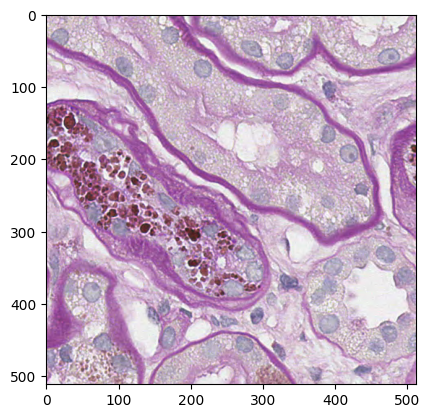

In [4]:
im = cv2.cvtColor(slide.patches[keys[70]], cv2.COLOR_BGR2RGB)

plt.imshow(im)


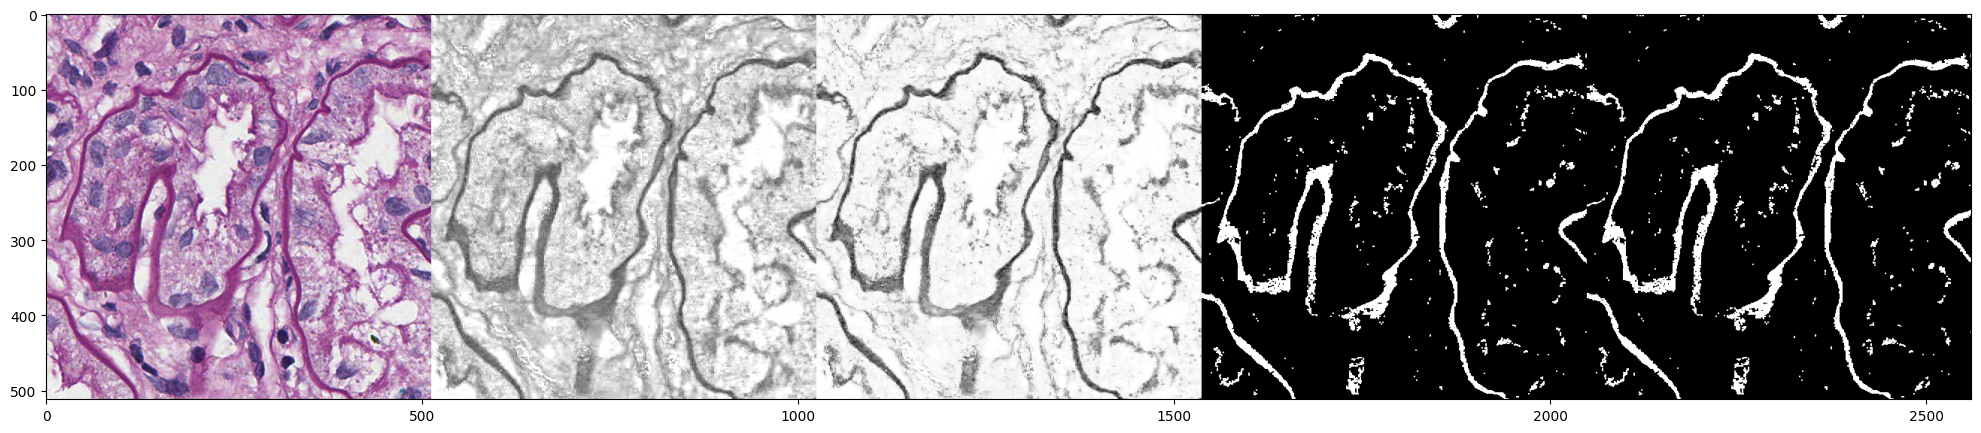

In [11]:
import histomicstk as htk

def applyThresholdEosin(patch):
    lower = 150
    upper = 255
    mask = cv2.inRange(patch, lower, upper)
    
    return np.array(255-mask, dtype='uint8') 


def smoothBinary(mask):
    kn = 2
    iterat = 2
    kernel = np.ones((kn, kn), np.uint8) 
    for _ in range(iterat):
        mask = cv2.erode(mask, kernel, iterations=1) 
        mask = cv2.dilate(mask, kernel, iterations=1) 
    return mask

def stainDeconv(im):
    stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
    #print('stain_color_map:', stain_color_map, sep='\n')

    # specify stains of input image
    stains = ['hematoxylin',  # nuclei stain
                'eosin',        # cytoplasm stain
                'null']         # set to null if input contains only two stains

    # create stain matrix
    W = np.array([stain_color_map[st] for st in stains]).T

    # perform standard color deconvolution
    imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(im, W)

    ## Thresholding
    eosinStain = imDeconvolved.Stains[:, :, 1]

    return eosinStain


thresholdArea = 0.0001

xp = [0, 64, 128, 192, 255]
fp = [0, 16, 128, 240, 255]
x = np.arange(256)
table = np.interp(x, xp, fp).astype('uint8')


eosin = stainDeconv(im)

#eosinEqu = cv2.equalizeHist(eosin)

eosinEqu = cv2.LUT(eosin, table)

#imgYuv = cv2.cvtColor(eosin, cv2.COLOR_BGR2YUV)
#imgYuv[:,:,0] = cv2.equalizeHist(imgYuv[:,:,0])
#imEquBGR = cv2.cvtColor(imgYuv, cv2.COLOR_YUV2BGR)

mask = applyThresholdEosin(eosinEqu)
maskSmooth = smoothBinary(mask)
mask3d = cv2.cvtColor(maskSmooth, cv2.COLOR_GRAY2RGB)
eosin3 = cv2.cvtColor(eosin, cv2.COLOR_GRAY2RGB)
eosin3Equ = cv2.cvtColor(eosinEqu, cv2.COLOR_GRAY2RGB)

#contours, _ = cv2.findContours(maskSmooth, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours, _ = cv2.findContours(maskSmooth, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

c_max = max(contours, key = cv2.contourArea)
area_min = cv2.contourArea(c_max) * thresholdArea

contours_filtered = []

for contour in contours:
    area = cv2.contourArea(contour)
    if area > area_min:
        contours_filtered.append(contour)

im_ = im*0

cv2.drawContours(im_, contours_filtered, -1, (255, 255, 255), -1)

#imEquBGR = cv2.cvtColor(imEquBGR, cv2.COLOR_BGR2RGB)
concat = cv2.hconcat((im, eosin3, eosin3Equ, mask3d, im_))

fig = plt.figure(figsize = (25,5))

plt.imshow(concat)


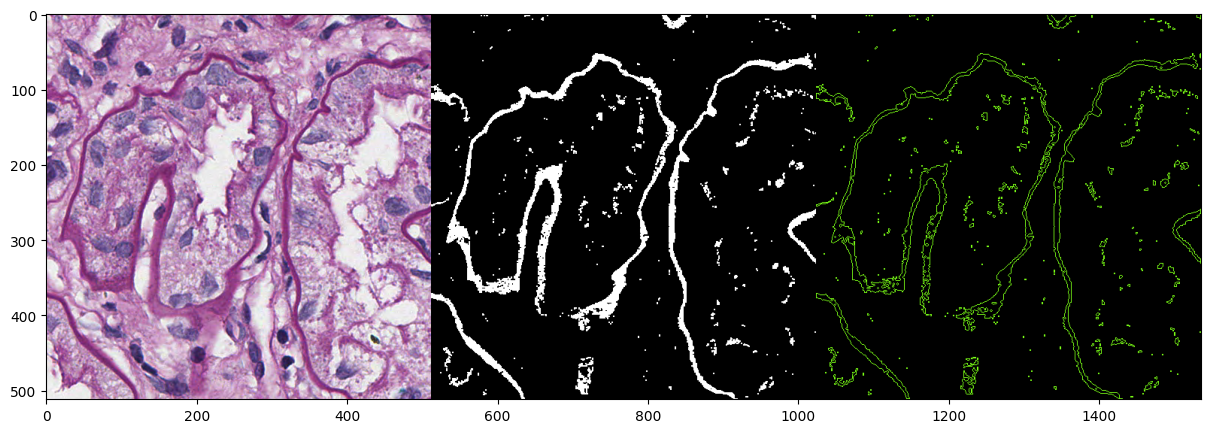

In [12]:
im_ = im*0

cv2.drawContours(im_, contours_filtered, -1, (123, 255, 23), 1)

concat = cv2.hconcat((im, mask3d, im_))

fig = plt.figure(figsize = (15,5))

plt.imshow(concat)


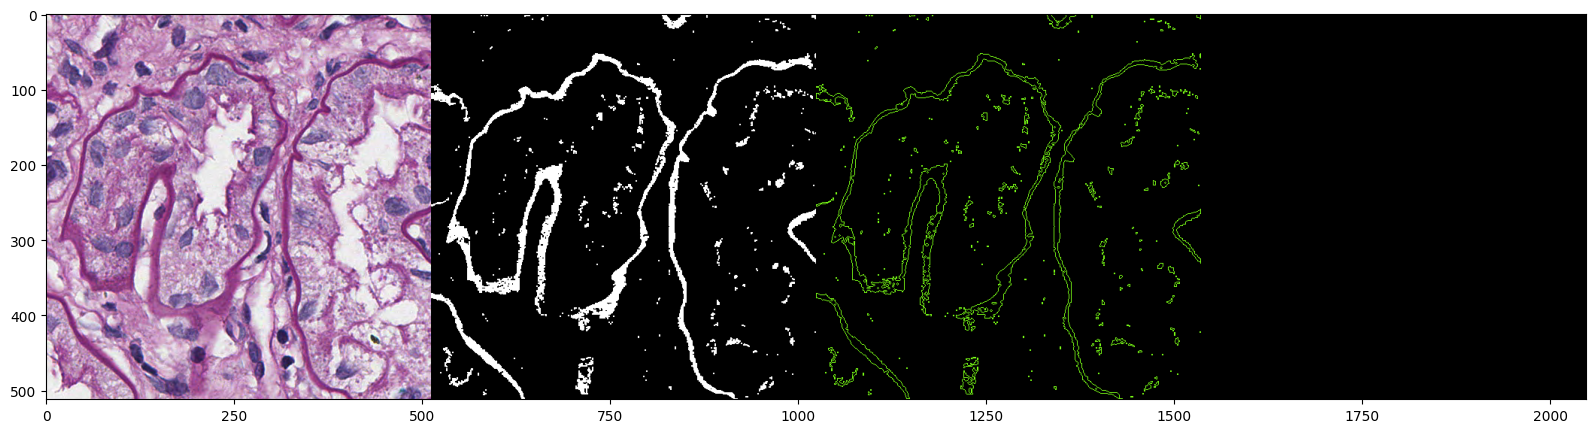

In [17]:
amin = 50
area = cv2.contourArea(contour)
contours_filtered_ = []
for contour in contours_filtered:
    if area > area_min:
        if area > amin:
            msk_ = mask3d*0
            interThickness = 1
            cv2.drawContours(msk_, [contour], -1, [255,255,255], interThickness)
            fig = plt.figure(figsize = (20,5))
            plt.imshow(msk_)
            if np.sum(msk_*mask3d)>0:
                contours_filtered_.append((contour))


im__ = im*0

cv2.drawContours(im__, contours_filtered_, -1, (123, 255, 23), -1)

concat = cv2.hconcat((im, mask3d, im_, im__))

fig = plt.figure(figsize = (20,5))

plt.imshow(concat)

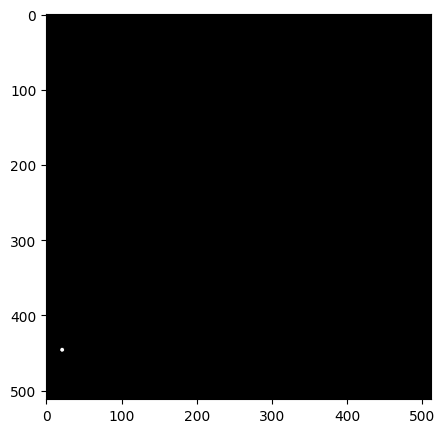

In [24]:
imTest = im*0
mask3d = im*0


contours_filtered_ = []
for contour in contours_filtered:
    msk_ = mask3d*0
    interThickness = 1
    cv2.drawContours(msk_, [contour], -1, [255,255,255], interThickness)
    fig = plt.figure(figsize = (20,5))
    plt.imshow(msk_)
    if np.sum(msk_*mask3d)>0:
        contours_filtered_.append((contour))

cv2.drawContours(imTest, [contours_filtered[36]], -1, (255, 255, 255), 2)
fig = plt.figure(figsize = (5,5))
plt.imshow(imTest)